# Test Notebook for Confidence Regions Toolbox

## Import Packages

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install nilearn
%pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 5.3 MB/s eta 0:00:0000:0100:01


In [2]:
# Basic imports
import numpy
import yaml
import matplotlib.pyplot as plt

# Imports from Confidence Regions Toolbox
from generate import generate_CRs, generate_CRs_new
from coverage import check_violations

# Import supporting functions
from lib.set_theory import *
from lib.boundary import *
from lib.regression import *

# Import data generation
from tests.generate_2d_data import *
from tests.generate_ni_data import *


## Data Generation

Initial parameters.

In [ ]:
# Number of fields m
m = 3

# Get number of subjects
nSub = 80

# Get number of simulation realizations
nReals = 100

# Get number of bootstraps
nBoot = 5000

# Get Threshold
c = 2

# Get p values
p = np.linspace(0,1,21)

# Get the number of p-values we're looking at
nPvals = len(p)

# Get Tau
tau = 1/np.sqrt(nSub)

# Dimensions of simulated data
data_dim = np.array([nSub, 100,100])

Create some circular signals.

In [ ]:
# ---------------------------------------------------------------
# Mus
# ---------------------------------------------------------------
# Create empty specifications
mu_specs = {}

# Loop through mus, adding each field in turn
for i in np.arange(m):

    # New empty dict
    mu_specs['mu'+str(i+1)]={}

    # Mu type
    mu_specs['mu'+str(i+1)]['type'] = 'circle2D' 

    # Mu FWHM
    mu_specs['mu'+str(i+1)]['fwhm'] = np.array([5,5])

    # Mu r
    mu_specs['mu'+str(i+1)]['r'] = 40

    # Mu magnitude
    mu_specs['mu'+str(i+1)]['mag'] = 3

    # Get some evenly spaced center points
    centers = circle_points(np.array([25]),np.array([m]))

    # Mu center
    mu_specs['mu'+str(i+1)]['center'] = centers[i,:].astype(np.int)

# ---------------------------------------------------------------
# Epsilons
# ---------------------------------------------------------------
# Create empty specifications
noise_specs = {}

# Loop through noises, adding each field in turn
for i in np.arange(m):

    # New empty dict
    noise_specs['noise'+str(i+1)]={}

    # Add FWHM
    noise_specs['noise'+str(i+1)]['FWHM'] = np.array([0, 3, 3])

    # Add type
    noise_specs['noise'+str(i+1)]['type'] = 'homogen'

Generate the data.

In [ ]:
for i in np.arange(m):

    # ----------------------------------------------------------------
    # Data generation
    # ----------------------------------------------------------------

    # Obtain noise
    noise = get_noise(noise_specs['noise'+str(i+1)], data_dim)

    # Obtain mu
    mu = get_mu(mu_specs['mu'+str(i+1)], data_dim)

    # Create the data
    data = mu + noise

    # Save mus
    if i == 0:
        mus = np.array(mu)
    else:
        mus = np.concatenate((mus,mu),axis=0)

    # Combine data
    if i == 0:
        datas = np.array(data.reshape(1,*(data.shape)))
    else:
        datas = np.concatenate((datas,data.reshape(1,*(data.shape))),axis=0)

## Make Some Plots

In [ ]:
# Data for the "5th" subject
plt.imshow(np.mean(datas,axis=1)[2,:,:])
plt.colorbar()

## Generate Confidence Regions

In [ ]:
# Output directory
out_dir = '/home/tommaullin/Documents'

# Generate Confidence Regions
FcHat_minus, FcHat_plus, FcHat, a = generate_CRs(datas, c, p, out_dir)

In [ ]:
i = 20

print(a[i],p[i])
plt.imshow(1*FcHat_plus[i,:,:]+1*FcHat+1*FcHat_minus[i,:,:])
plt.colorbar()


In [ ]:
print(a[i])
plt.imshow(1*FcHat_plus[i,:,:]-1*FcHat_minus[i,:,:])
plt.colorbar()

## Assess Coverage

In [ ]:
# Get Fc
Fc = mu > c


In [ ]:
# Get the results
results = check_violations(FcHat_plus, FcHat_minus, datas, mus, c, tau, a)

In [ ]:
results[1]

## Assess Coverage over Repeated Runs

In [ ]:
import time

# Set the number of repetitions
nReps = 1000

# Loop through the repetitions
for j in np.arange(nReps):
    print(j)
    
    # Time data generation
    start = time.time()

    for i in np.arange(m):
        # Obtain noise
        noise = get_noise(noise_specs['noise'+str(i+1)], data_dim)

        # Obtain mu
        mu = get_mu(mu_specs['mu'+str(i+1)], data_dim)

        # Create the data
        data = mu + noise

        # Save mus
        if i == 0:
            mus = np.array(mu)
        else:
            mus = np.concatenate((mus,mu),axis=0)

        # Combine data
        if i == 0:
            datas = np.array(data.reshape(1,*(data.shape)))
        else:
            datas = np.concatenate((datas,data.reshape(1,*(data.shape))),axis=0)
    
    # Time data generation
    end = time.time()
    #print(end - start)

    # Time confidence region generation
    start = time.time()

    # Generate Confidence Regions
    FcHat_minus, FcHat_plus, FcHat, a = generate_CRs(datas, c, p, out_dir)

    # Time confidence region generation
    end = time.time()
    #print(end - start)

    # Time violation checking
    start = time.time()

    # Get the results
    results = check_violations(FcHat_plus, FcHat_minus, datas, mus, c, tau, a)

    # Time violation checking
    end = time.time()
    #print(end - start)

    #print(results)
    # Average the results
    if j == 0:
        avg_results = np.array(results[0])
    else:
        # Concatenate the results
        concat_results = np.concatenate((avg_results.reshape(1,np.prod(avg_results.shape)),
                                        results[0].reshape(1,np.prod(avg_results.shape))),axis=0)
        # Avergae the results
        avg_results = np.mean(concat_results,axis=0)


In [ ]:
# Plot average results against p
plt.plot(p,avg_results)
plt.xlabel('p')
plt.ylabel('Average number of violations')
plt.title('Average number of violations against p')
plt.show()

### NeuroImaging Example

First, we generate some test data.

In [3]:
# Parameters for data generation
n = 30
p = 3
out_dir = '/home/tommaullin/Documents/ConfSets_Rehaul/'

# Generate some test data
y_files, beta_files, X = generate_data(n, p, out_dir)

Compute the mean and standard deviation images.

In [4]:
# Get the estimated betahat, sigmahat and residuals
betahat_files, var_betahat_files, resid_files = regression(y_files, X, out_dir, chunk_size=20)

We're going to use the first $\hat{\beta}$ as our signal, $\mu$.

In [5]:
# Get muhat and sigmahat
muhat_file = betahat_files[0]
sigmahat_file = var_betahat_files[0]

# Threshold c
c = 2

# Get p values
p = np.linspace(0,1,21)

Let's try to generate some CRs.

In [6]:
# Generate CRs
FcHat_minus, FcHat_plus, FcHat, a_estBdry = generate_CRs_new(muhat_file, sigmahat_file, resid_files, c, p)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function arange>) found for signature:
 
 >>> arange(array(int64, 0d, C))
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload of function 'arange': File: numba/np/arrayobj.py: Line 4479.
     With argument(s): '(array(int64, 0d, C))':
    No match.

During: resolving callee type: Function(<built-in function arange>)
During: typing of call at /home/tommaullin/Documents/ConfSets_Rehaul/src/lib/boundary.py (233)


File "lib/boundary.py", line 233:
def get_bdry_maps(field, c, mask=None):
    <source elided>
    # Loop through dimensions of field and get the boundary boolean maps.
    for d in np.arange(dim):
    ^


7.324662097330822 1.0


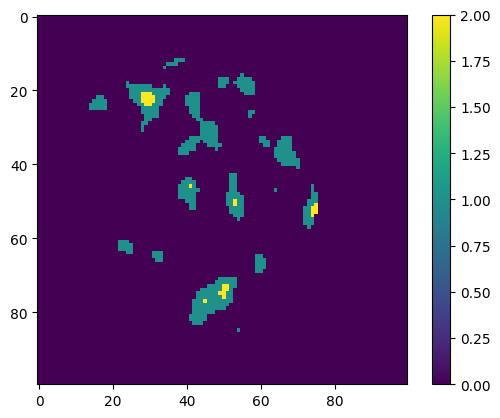

In [ ]:
i = 20
slice = 35

print(a_estBdry[i],p[i])
plt.imshow(1*FcHat_plus[i,slice,:,:]+1*FcHat[slice,:,:]+1*FcHat_minus[i,slice,:,:])
plt.colorbar()


/home/tommaullin/Documents/ConfSets_Rehaul/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/home/tommaullin/Documents/ConfSets_Rehaul/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tommaullin/Documents/ConfSets_Rehaul/.venv/lib/python3.7/site-packages/ipykernel_launch

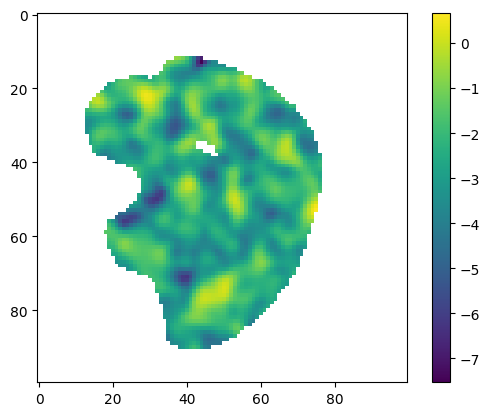

In [ ]:
# Load in muhat and make an image of it
muhat = nib.load(muhat_file).get_data()
sigmahat = nib.load(sigmahat_file).get_data()

# Make image
plt.imshow((muhat[slice,:,:]-c)/sigmahat[slice,:,:])
plt.colorbar()
plt.show()

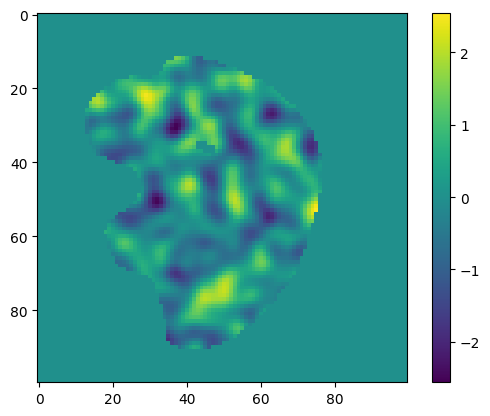

In [ ]:

# Make image
plt.imshow(muhat[slice,:,:])
plt.colorbar()
plt.show()